In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

Splitting the raw TXT file.

In [ ]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA Loadinf of the main EP dataset
#data_path = './MindBigData-EP-v1.0/EP1.01.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-EP-v1.0')

Load the files, get the points and the list of labels

In [80]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=1000) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 1000/1000 [00:01<00:00, 628.81it/s]


In [81]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 995
Num labels EPOC: 11
Labels EPOC: ['5', '4', '1', '8', '9', '7', '6', '0', '3', '2', '-1']
------------------------------------
Data shape EPOC (14, 256)


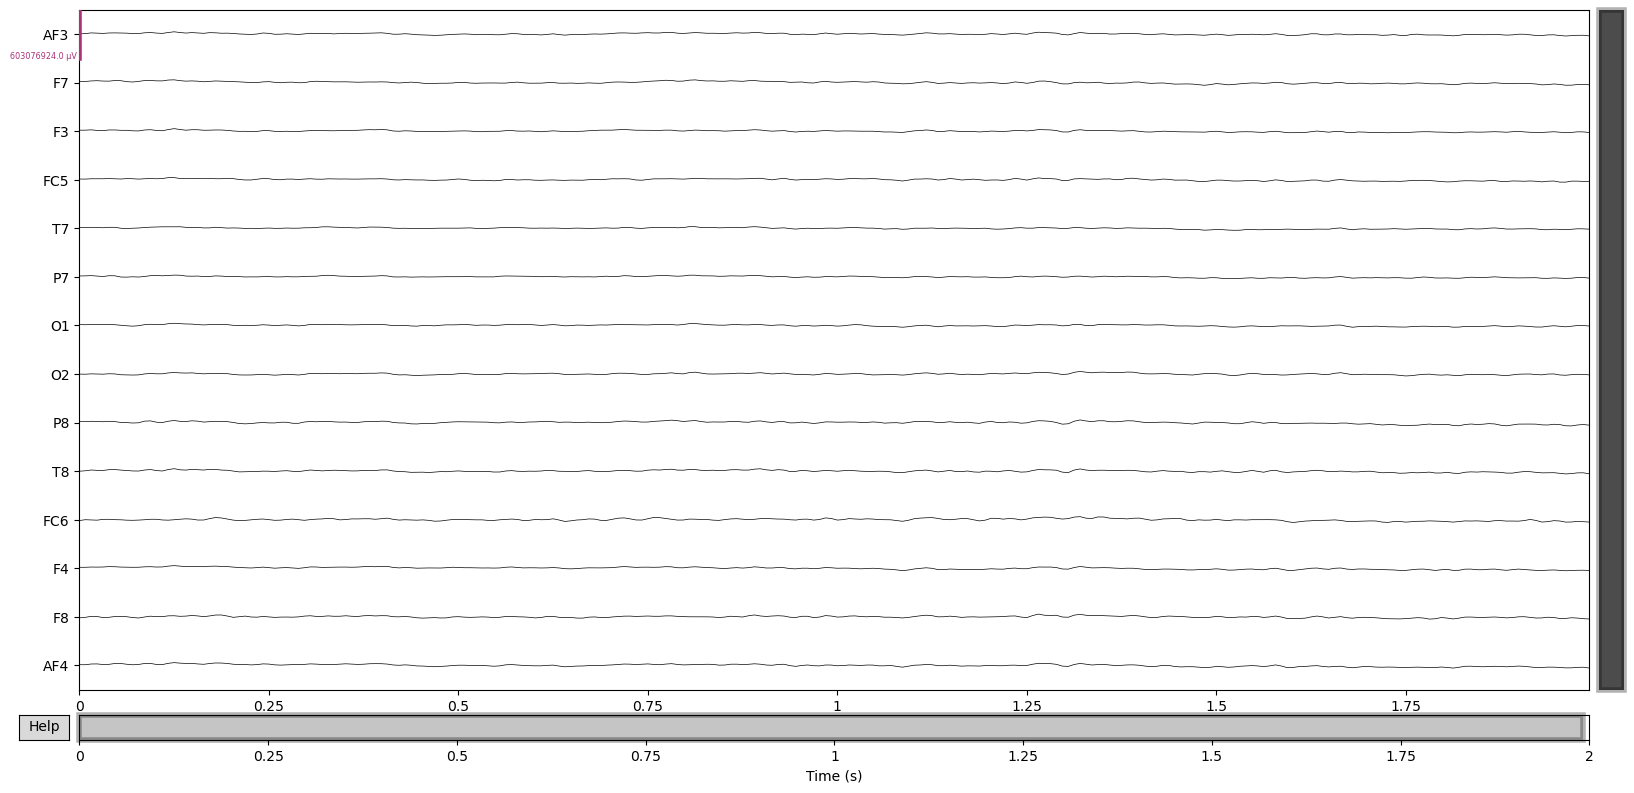

In [82]:
all_points[0].mne_object.plot(scalings = 'auto');

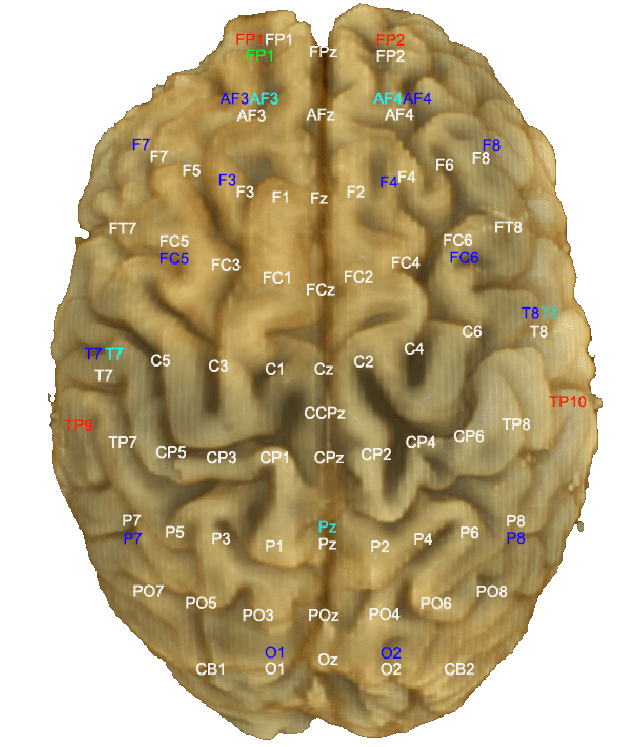

Epoc channels:---"AF3","AF4","T7","T8","P7", "F7", "F3", "FC5", "O1", "O2", "P8",  "FC6", "F4", "F8",

One paper states that best results came from 'T7', 'P7', 'P8', 'T8'

In [83]:
"""
We will loop through every data point and call the cleaning methods.
This filters the frequencies to be only between the ranges. We want 3 - 30 because this is where relevant alpha theta, beta bands lie.
MNE says to multiply the lowpass by 1/3.
"""
print("Cleaning epoc....")
for point in tqdm(all_points):
    point.full_clean(channels = ['T7', 'P7', 'P8', 'T8'], l_freq = 3, h_freq = 30)


Cleaning epoc....


100%|██████████| 995/995 [00:03<00:00, 281.59it/s]


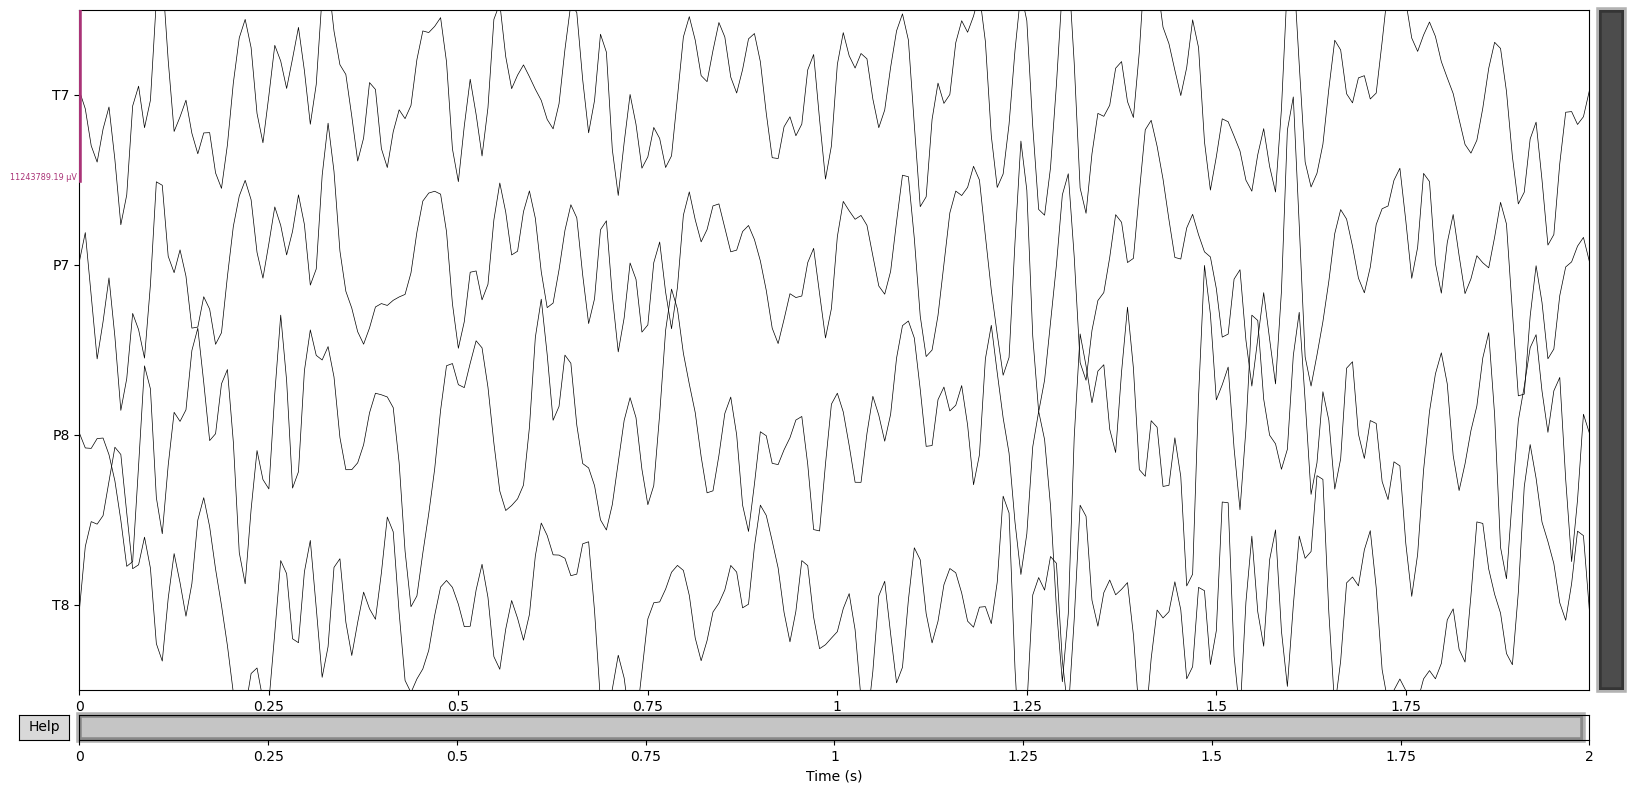

In [84]:
all_points[0].mne_object.plot(scalings='auto');

Code for normalization. Should fit train, and apply to all.

In [11]:
from EegHelper.EegAugmentation import NormalizationHelper

helper = NormalizationHelper(all_points)           #Provide the data which you want to fit with
scaler = helper.get_robust_scaler()              #Get the fit scaler
all_points = NormalizationHelper.fit_points(scaler=scaler,data_points=all_points) #Fit points after providing scaler

100%|██████████| 995/995 [00:01<00:00, 632.55it/s]


In [85]:
point_vs_label = {}
for point in all_points:
    if point.label in point_vs_label:
        point_vs_label[point.label].append(point)
    else:
        point_vs_label[point.label] = [point]

In [113]:
class CorrelationHelper:
    def __init__(self, label):
        self.d = 0
        self.label = label
        self.data = []

    def add_point(self, data):
        self.data.append(data)
        self.d += 1
    
    def mean(self):
        self.data = np.array(self.data).T
        return (1/(self.data.shape[1])) * np.matmul(self.data,np.ones(self.data.shape[1]))

https://ieeexplore.ieee.org/document/9616192/citations#citations

In [109]:
label = '1'

helper_by_channel = {}

for point in point_vs_label[label]:
    for channel in point.mne_object.ch_names:
        if channel not in helper_by_channel:
            helper_by_channel[channel] = CorrelationHelper(label)
            
        helper_by_channel[channel].add_point(
            point.mne_object._data[point.mne_object.ch_names.index(channel),:]
        )

In [111]:
scores = []
for sample in data.T:
    numer = d*np.sum(sample*mean) - np.sum(sample)*np.sum(mean)
    denom = (d*np.sum(sample*sample) - np.power(np.sum(sample),2)) * ((d*np.sum(mean*mean)) - np.power(np.sum(mean), 2))
    z = numer/np.sqrt(denom)
    scores.append(z)

scores = np.array(scores)
print(np.sum((scores > 0.1) | (scores < -0.1)), len(scores))

34 99
